In [1]:
import os
from os import listdir
from time import time
import re
import copy

import pandas as pd
import numpy as np

In [2]:
import matplotlib.pylab as plt

In [3]:
import dicom2jpg

In [4]:
def load_data(filename): # frame creation
    df = pd.read_csv(filename)
    return(df)

In [5]:
from tqdm import tqdm
import torch.optim as optim

In [6]:
detailed_class_info = load_data("kaggle_set/stage_2_detailed_class_info.csv")

In [7]:
train_labels = load_data("kaggle_set/stage_2_train_labels.csv")

In [8]:
detailed_class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [9]:
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [10]:
len(train_labels)

30227

In [11]:
len(pd.unique((train_labels['patientId'])))

26684

In [135]:
def image_path(row):
    # return f'kaggle_set/stage_2_train_images/{row["patientId"]}.dcm'
    return f'{row["patientId"]}.png'

In [13]:
def image_path(row):
    # return f'kaggle_set/stage_2_train_images/{row["patientId"]}.dcm'
    return f'{row["patientId"]}.png'
def image_target_label(row):
    return int(row['label'][0])

In [136]:
full_info = pd.concat([train_labels, 
                        detailed_class_info.drop(['patientId'], axis=1)], axis=1)
full_info["patient_path"] = full_info.apply(image_path, axis=1)

In [137]:
full_info

,patientId,x,y,width,height,Target,class,patient_path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,00322d4d-1c29-4943-afc9-b6754be640eb.png
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4.png
...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal,c1edf42b-5958-47ff-a1e7-4f23d99583ba.png
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal,c1f6b555-2eb1-4231-98f6-50a963976431.png
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity,c1f7889a-9ea9-4acb-b64c-b737c929599a.png


In [16]:
INPUT_HEIGHT = 224
INPUT_WIDTH = 224
BATCH_SIZE = 16
VAL_SPLIT = 0.15

In [17]:

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

In [190]:


h_flip = transforms.RandomVerticalFlip()
v_flip = transforms.RandomHorizontalFlip()
rotate = transforms.RandomRotation(degrees=25)

In [191]:
h_flip = transforms.RandomVerticalFlip()
v_flip = transforms.RandomHorizontalFlip()
rotate = transforms.RandomRotation(degrees=25)
resize = transforms.RandomResizedCrop(size=224, scale=(0.9, 1))
train_transforms = transforms.Compose([h_flip, v_flip, rotate, resize,
        transforms.ToTensor()])

In [24]:
import cv2
import pydicom as dicom

In [25]:
def convert_dcm_to_jpg(dcm_path, jpg_path):
    """
    Converts dcm format files to jpg
    Arguments: 
    dcm_path - path to folder with .dcm images
    jpg_path - path to folder with .jpg images
    """
    images_path = os.listdir(dcm_path)
    for n, image in enumerate(images_path):
        ds = dicom.dcmread(os.path.join(dcm_path, image))
        np_im = ds.pixel_array
        image = image.replace('.dcm', '.jpg')
        np_im = cv2.resize(np_im, (INPUT_HEIGHT, INPUT_HEIGHT))
        cv2.imwrite(os.path.join(jpg_path, image), np_im)

In [109]:
def convert_dcm_to_jpg(dcm_path, png_path):
    """
    Converts dcm format files to png
    Arguments: 
    dcm_path - path to folder with .dcm images
    png_path - path to folder with .png images
    """
    images_path = os.listdir(dcm_path)
    for n, image in enumerate(images_path):
        ds = dicom.dcmread(os.path.join(dcm_path, image))
        np_im = ds.pixel_array
        image = image.replace('.dcm', '.png')
        np_im = cv2.resize(np_im, (INPUT_HEIGHT, INPUT_HEIGHT))
        cv2.imwrite(os.path.join(png_path, image), np_im)

(1024, 1024)


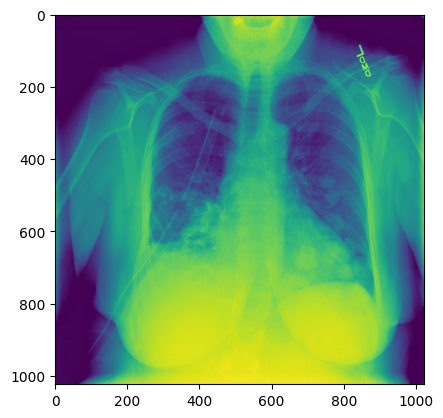

In [26]:
ds = dicom.dcmread('kaggle_set/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm')
np_im = ds.pixel_array
print(np_im.shape)
plt.imshow(np_im)

In [106]:
jpg_dir = 'kaggle_set/png/stage_2_train_images_jpg_'+str(INPUT_HEIGHT)
dcm_dir = 'kaggle_set/stage_2_train_images'

In [110]:
convert_dcm_to_jpg('kaggle_set/stage_2_train_images', jpg_dir)

In [142]:
train_label_set = copy.deepcopy(full_info[['patient_path', 'x', 'y', 'width', 'height']])
train_label_set['label'] = copy.deepcopy(full_info['Target'])
train_label_set

,patient_path,x,y,width,height,label
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb.png,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4.png,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba.png,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431.png,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a.png,570.0,393.0,261.0,345.0,1


In [143]:
len(train_label_set[train_label_set['label']==0])

20672

In [144]:
def image_x2(row):
    return row['x']+row['width']

def image_y2(row):
    return row['y']+row['height']

In [145]:
train_label_set_clean = copy.deepcopy(train_label_set)
train_label_set_clean["x2"] = train_label_set_clean.apply(image_x2, axis=1)
train_label_set_clean["y2"] = train_label_set_clean.apply(image_y2, axis=1)
train_label_set_clean['bbox'] = train_label_set_clean[['x', 'y', 'x2' , 'y2']].apply(list, axis=1).fillna(0)
train_label_set_clean = train_label_set_clean.drop(columns=['x', 'y', 'x2' , 'y2', 'height', 'width']).groupby('patient_path', as_index=False).agg(list)

train_label_set_clean["target"] = train_label_set_clean.apply(image_target_label, axis=1)

In [146]:
#nan_line = train_label_set_clean.loc[0]['bbox']

#train_label_set_clean.loc[train_label_set_clean['bbox'] == nan_line] = [[0,0,0,0]]

In [147]:
train_label_set_clean.head()

,patient_path,label,bbox,target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,[0],"[[nan, nan, nan, nan]]",0
1,000924cf-0f8d-42bd-9158-1af53881a557.png,[0],"[[nan, nan, nan, nan]]",0
2,000db696-cf54-4385-b10b-6b16fbb3f985.png,"[1, 1]","[[316.0, 318.0, 486.0, 796.0], [660.0, 375.0, ...",1
3,000fe35a-2649-43d4-b027-e67796d412e0.png,"[1, 1]","[[570.0, 282.0, 839.0, 691.0], [83.0, 227.0, 3...",1
4,001031d9-f904-4a23-b3e5-2c088acd19c6.png,"[1, 1]","[[66.0, 160.0, 439.0, 768.0], [552.0, 164.0, 9...",1


In [148]:
val_set=train_label_set_clean.sample(frac=VAL_SPLIT,random_state=8)
train_set=train_label_set_clean#.drop(val_set.index).reset_index()
val_set = val_set.reset_index()

In [149]:
len(train_set[train_set['target']==1])/len(train_set[train_set['target']==0])

0.29082817337461303

In [150]:
val_set.to_csv('kaggle_set/val_labels.csv')
train_set.to_csv('kaggle_set/train_labels.csv')

In [151]:
train_set_box = copy.deepcopy(train_label_set_clean[train_label_set_clean['target']==1]).reset_index()
val_set_box = copy.deepcopy(val_set[val_set['target']==1]).reset_index()

In [152]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [153]:
import json
from PIL import Image
class ImageDataset(Dataset):
    """
    Class that creates dataset for training task
    Arguments: 
    classification - bool, True - set for classification only, False - for obj detection
    transform - transform for input image
    target_transform - transform for label
    labels - path to csv file with cleaned dataset
    labels_df - dataframe with cleaned dataset
    img_dir - path to directory with training images
    """
    def __init__(self, img_dir, labels_df=None,
                 labels=None,transform=None, target_transform=None, 
                 classification=True):
        if labels:
            self.img_labels = pd.read_csv(labels)
        if not isinstance(labels_df, type(None)):
            self.img_labels = labels_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.classification = classification
        self.mult = INPUT_HEIGHT/1024

    def __len__(self):
        return self.img_labels.shape[0]

    def __getitem__(self, idx):
        img_path = self.img_dir + f'/{self.img_labels["patient_path"][idx]}'
        image = Image.open(img_path)
        target = self.img_labels['target'][idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        if self.classification==False:
            label = torch.Tensor(self.img_labels.loc[idx, 'label']).to(torch.int64)
            bbox = torch.Tensor(self.img_labels.loc[idx, 'bbox']).to(torch.float)
            bbox = bbox*self.mult
            #print(bbox)
            target = {}
            #target['bbox'] = bbox
            target['boxes'] = bbox
            # i hate it here
            target['labels'] = label
            return image, target
        return image, target



In [154]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [155]:
def adjust_contrast():
    def _func(img):
        return  transforms.functional.adjust_contrast(img, contrast_factor= 1.1)
    return _func

In [156]:
base_transform = transforms.Compose([
    # adjust_contrast(),
    transforms.ToTensor()
])

In [192]:
train_dataset = ImageDataset(jpg_dir, labels_df = train_set, transform=train_transforms)#, classification=False)
val_dataset = ImageDataset(jpg_dir, labels_df = val_set, transform=base_transform)#, classification=False)
train_dataset_box = ImageDataset(jpg_dir, labels_df = train_set_box, transform=base_transform, classification=False)
val_dataset_box = ImageDataset(jpg_dir, labels_df = val_set_box, transform=base_transform, classification=False)

In [193]:
BATCH_SIZE=32

In [194]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)#, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)#, collate_fn=collate_fn)
train_dataloader_box = DataLoader(train_dataset_box, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader_box = DataLoader(val_dataset_box, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [195]:
train_dataset = ImageDataset(jpg_dir, labels_df = train_set, transform=train_transforms)#, classification=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)#, collate_fn=collate_fn)

In [196]:
print("[INFO] training dataset contains {} samples...".format(
        len(train_dataset)))

[INFO] training dataset contains 26684 samples...


In [197]:
print("[INFO] training dataset contains {} samples...".format(
        len(train_dataset_box)))

[INFO] training dataset contains 6012 samples...


In [163]:
import collections
collections.Iterable = collections.abc.Iterable

tensor(1)
tensor([ 64.3125, 123.1562, 111.7812, 148.0938])


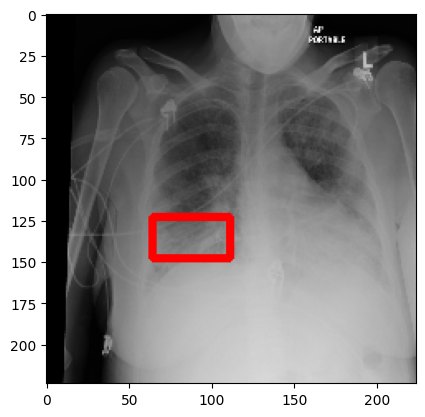

CPU times: total: 1.41 s
Wall time: 500 ms


In [164]:
%%time
train_features, target = next(iter(train_dataloader_box))
# print(f"Labels batch shape: {train_labels.size()}")
img = train_features[4].squeeze()
label = target[4]['labels'][0]
print(label)
box = target[4]['boxes']
box = box[0]
print(box)
box2 = box
        
plt.imshow(cv2.rectangle(cv2.cvtColor(np.array(img), cv2.COLOR_GRAY2BGR), (int(box2[0]), int(box2[1])), (int(box2[2]), int(box2[3])), color = (1,0,0), thickness=4))
plt.show()
#print(f"Label: {label}")

In [54]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, 
                               out_channels = 32, 
                               kernel_size = 3,
                               padding = 1) # 1 - input channels, 32 - output/filters
        self.dropout = nn.Dropout(p=0.2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
        self.pool4 = nn.MaxPool2d(2)
        self.dense1 = nn.Linear(25088, 128) #112*112*2
        self.dense2 = nn.Linear(128, 1)
        # self.dense2 = nn.Linear()
        # self.dense2 = 2


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.pool1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.relu(self.pool2(x))
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = F.relu(self.pool3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.pool4(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.dense1(x))
        x = torch.sigmoid(self.dense2(x))
        out=x.flatten(start_dim=1)
        #
        # x = torch.sigmoid(self.dense2(x))
        return out


In [55]:
cl = Classifier().cuda()


loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(cl.parameters(), lr=0.001)

In [56]:
# import torch.optim as optim

In [57]:



loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(cl.parameters(), lr=0.001)

In [58]:

torch.cuda.empty_cache()

In [165]:
def get_accuracy(y_true, y_pred):
    y_prob = y_pred > 0.5
    return (y_true == y_prob).sum().item()

In [60]:
def train_cl(cl, train_dataloader, val_dataloader, e):
    all_loss = []
    all_val_loss = []
    for epoch in range(1, e+1):
        running_loss = 0
        val_running_loss = 0
        
        with tqdm(train_dataloader, unit="batch") as tepoch:
            cl.train()
            for data in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                inputs, labels = data
                inputs = inputs.detach().to('cuda')
                labels = labels.unsqueeze(1).float().detach().to('cuda')
                optimizer.zero_grad()
                outputs = cl(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                #accuracy.append(get_accuracy(labels, outputs))
                running_loss += loss.item()
                #tepoch.set_postfix()#, accuracy=sum(accuracy)/len(accuracy))
        running_loss = running_loss/len(train_dataloader.dataset)
        print(f'Epoch: {epoch}, loss: {running_loss}')
        all_loss.append(running_loss)
        """        
        with tqdm(val_dataloader, unit="batch") as tepoch:
            for data in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                inputs, labels = data
                inputs = inputs.detach().to('cuda')
                labels = labels.unsqueeze(1).float().detach().to('cuda')
                optimizer.zero_grad()
                outputs = cl(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                #val_accuracy.append(get_accuracy(labels, outputs))
                val_running_loss += loss.item()
                #tepoch.set_postfix(val_loss=val_running_loss)#, val_accuracy=sum(val_accuracy)/len(val_accuracy))
        val_running_loss = val_running_loss/len(val_dataloader.dataset)    
        print(f'Epoch: {epoch}, val loss: {val_running_loss}')
        all_val_loss.append(val_running_loss)
        """
    return all_loss, all_val_loss

In [83]:
all_loss, all_val_loss = train_cl(cl, train_dataloader, val_dataloader, 15)

Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [03:03<00:00,  4.55batch/s]


Epoch: 1, loss: 0.014833431208447313


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:22<00:00, 10.08batch/s]


Epoch: 2, loss: 0.013863605504213039


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:22<00:00, 10.09batch/s]


Epoch: 3, loss: 0.013535103168025258


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:21<00:00, 10.18batch/s]


Epoch: 4, loss: 0.013253252018478174


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:21<00:00, 10.18batch/s]


Epoch: 5, loss: 0.013052935015536948


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:21<00:00, 10.20batch/s]


Epoch: 6, loss: 0.012966954782147258


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:21<00:00, 10.19batch/s]


Epoch: 7, loss: 0.01287280932613853


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:21<00:00, 10.21batch/s]


Epoch: 8, loss: 0.012901853265754824


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:21<00:00, 10.22batch/s]


Epoch: 9, loss: 0.012728192279621537


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [03:18<00:00,  4.20batch/s]


Epoch: 10, loss: 0.012814977564383368


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:23<00:00,  9.97batch/s]


Epoch: 11, loss: 0.01262837461931758


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.91batch/s]


Epoch: 12, loss: 0.012604774617685083


Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.88batch/s]


Epoch: 13, loss: 0.012530230033180557


Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.75batch/s]


Epoch: 14, loss: 0.012469951177872812


Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.85batch/s]

Epoch: 15, loss: 0.012380276977113476


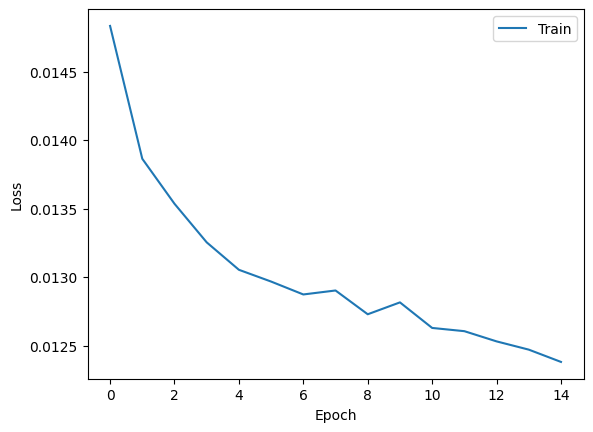

In [85]:
fig, ax  = plt.subplots()
ax.plot(all_loss, label='Train')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

In [70]:
torch.save(cl.state_dict(), 'cl.pt')

In [61]:
cl.load_state_dict(torch.load('cl.pt'))

<All keys matched successfully>

In [62]:
next(cl.parameters()).is_cuda

True

In [64]:
all_loss, all_val_loss = train_cl(cl, train_dataloader, val_dataloader, 15)

Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.80batch/s]


Epoch: 1, loss: 0.011672075623134019


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:27<00:00,  9.51batch/s]


Epoch: 2, loss: 0.011646261779090809


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.77batch/s]


Epoch: 3, loss: 0.011605030406791934


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.81batch/s]


Epoch: 4, loss: 0.011539288860843593


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:23<00:00,  9.96batch/s]


Epoch: 5, loss: 0.011487975796167237


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:27<00:00,  9.49batch/s]


Epoch: 6, loss: 0.011471786306900987


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:27<00:00,  9.56batch/s]


Epoch: 7, loss: 0.011458528382928988


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:27<00:00,  9.57batch/s]


Epoch: 8, loss: 0.011298255862567918


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:27<00:00,  9.52batch/s]


Epoch: 9, loss: 0.011279272626157895


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.74batch/s]


Epoch: 10, loss: 0.011267608932658232


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.87batch/s]


Epoch: 11, loss: 0.011231036721909534


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:27<00:00,  9.56batch/s]


Epoch: 12, loss: 0.011190839814869043


Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.77batch/s]


Epoch: 13, loss: 0.01112225137929065


Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.86batch/s]


Epoch: 14, loss: 0.011111695649725818


Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [01:27<00:00,  9.54batch/s]

Epoch: 15, loss: 0.010979502354492366


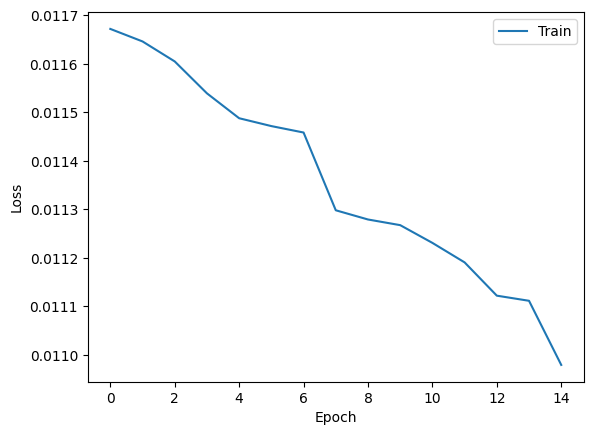

In [65]:
fig, ax  = plt.subplots()
ax.plot(all_loss, label='Train')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

Epoch 1: 100%|███████████████████████████████████████████████████████| 834/834 [03:07<00:00,  4.44batch/s]


Epoch: 1, loss: 0.010965890349244235


Epoch 2: 100%|███████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.89batch/s]


Epoch: 2, loss: 0.01096363638499351


Epoch 3: 100%|███████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.90batch/s]


Epoch: 3, loss: 0.010873401710930266


Epoch 4: 100%|███████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.88batch/s]


Epoch: 4, loss: 0.010853981087689295


Epoch 5: 100%|███████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.90batch/s]


Epoch: 5, loss: 0.010766108517955668


Epoch 6: 100%|███████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.80batch/s]


Epoch: 6, loss: 0.010658020290177974


Epoch 7: 100%|███████████████████████████████████████████████████████| 834/834 [01:26<00:00,  9.64batch/s]


Epoch: 7, loss: 0.010645741245285929


Epoch 8: 100%|███████████████████████████████████████████████████████| 834/834 [01:23<00:00,  9.97batch/s]


Epoch: 8, loss: 0.010596181165631914


Epoch 9: 100%|███████████████████████████████████████████████████████| 834/834 [01:23<00:00, 10.05batch/s]


Epoch: 9, loss: 0.01058510655802223


Epoch 10: 100%|██████████████████████████████████████████████████████| 834/834 [01:26<00:00,  9.63batch/s]


Epoch: 10, loss: 0.010513517546579587


Epoch 11: 100%|██████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.83batch/s]


Epoch: 11, loss: 0.010503514450511963


Epoch 12: 100%|██████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.86batch/s]


Epoch: 12, loss: 0.010491488332504312


Epoch 13: 100%|██████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.85batch/s]


Epoch: 13, loss: 0.010387966623762937


Epoch 14: 100%|██████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.72batch/s]


Epoch: 14, loss: 0.010272921829033051


Epoch 15: 100%|██████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.81batch/s]


Epoch: 15, loss: 0.010280569399362328


Epoch 16: 100%|██████████████████████████████████████████████████████| 834/834 [01:23<00:00,  9.97batch/s]


Epoch: 16, loss: 0.010192172249728567


Epoch 17: 100%|██████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.72batch/s]


Epoch: 17, loss: 0.010177371859563878


Epoch 18: 100%|██████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.74batch/s]


Epoch: 18, loss: 0.010186664111495661


Epoch 19: 100%|██████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.73batch/s]


Epoch: 19, loss: 0.010197192540507037


Epoch 20: 100%|██████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.84batch/s]


Epoch: 20, loss: 0.010079402836736863


Epoch 21: 100%|██████████████████████████████████████████████████████| 834/834 [01:26<00:00,  9.68batch/s]


Epoch: 21, loss: 0.010025425953979017


Epoch 22: 100%|██████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.78batch/s]


Epoch: 22, loss: 0.0099557404911888


Epoch 23: 100%|██████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.84batch/s]


Epoch: 23, loss: 0.010002589326509917


Epoch 24: 100%|██████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.83batch/s]


Epoch: 24, loss: 0.009863099800050035


Epoch 25: 100%|██████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.83batch/s]

Epoch: 25, loss: 0.00993603353183803


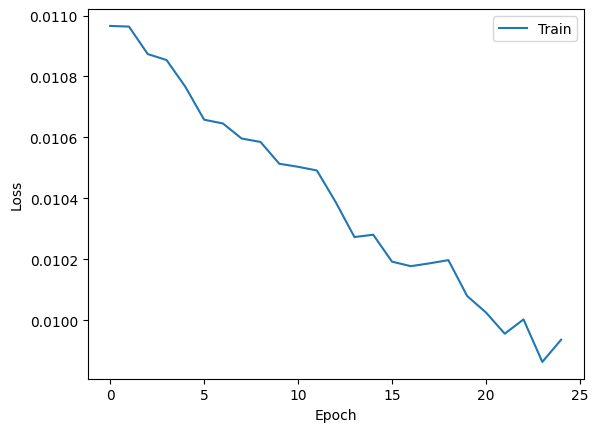

In [66]:
all_loss, all_val_loss = train_cl(cl, train_dataloader, val_dataloader, 25)
fig, ax  = plt.subplots()
ax.plot(all_loss, label='Train')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

Epoch 1: 100%|███████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.74batch/s]


Epoch: 1, loss: 0.010750522078973316


Epoch 2: 100%|███████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.70batch/s]


Epoch: 2, loss: 0.010630288095582177


Epoch 3: 100%|███████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.87batch/s]


Epoch: 3, loss: 0.010560574986988808


Epoch 4: 100%|███████████████████████████████████████████████████████| 834/834 [01:26<00:00,  9.67batch/s]


Epoch: 4, loss: 0.01053704557712245


Epoch 5: 100%|███████████████████████████████████████████████████████| 834/834 [01:26<00:00,  9.66batch/s]


Epoch: 5, loss: 0.010487616413696348


Epoch 6: 100%|███████████████████████████████████████████████████████| 834/834 [01:23<00:00, 10.03batch/s]


Epoch: 6, loss: 0.010470301844877669


Epoch 7: 100%|███████████████████████████████████████████████████████| 834/834 [01:26<00:00,  9.63batch/s]


Epoch: 7, loss: 0.010452744260200262


Epoch 8: 100%|███████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.85batch/s]


Epoch: 8, loss: 0.010377696052857058


Epoch 9: 100%|███████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.84batch/s]


Epoch: 9, loss: 0.010230820995143036


Epoch 10: 100%|██████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.80batch/s]


Epoch: 10, loss: 0.010334017204759878


Epoch 11: 100%|██████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.83batch/s]


Epoch: 11, loss: 0.010257846867773705


Epoch 12: 100%|██████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.87batch/s]


Epoch: 12, loss: 0.010169168389756235


Epoch 13: 100%|██████████████████████████████████████████████████████| 834/834 [01:26<00:00,  9.63batch/s]


Epoch: 13, loss: 0.010199838419146238


Epoch 14: 100%|██████████████████████████████████████████████████████| 834/834 [01:22<00:00, 10.08batch/s]


Epoch: 14, loss: 0.010156510310955909


Epoch 15: 100%|██████████████████████████████████████████████████████| 834/834 [01:23<00:00,  9.99batch/s]


Epoch: 15, loss: 0.010085447427941359


Epoch 16: 100%|██████████████████████████████████████████████████████| 834/834 [01:26<00:00,  9.69batch/s]


Epoch: 16, loss: 0.009969861716704378


Epoch 17: 100%|██████████████████████████████████████████████████████| 834/834 [01:26<00:00,  9.69batch/s]


Epoch: 17, loss: 0.009963175182481646


Epoch 18: 100%|██████████████████████████████████████████████████████| 834/834 [01:26<00:00,  9.64batch/s]


Epoch: 18, loss: 0.009924126091494033


Epoch 19: 100%|██████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.79batch/s]


Epoch: 19, loss: 0.009903746234201953


Epoch 20: 100%|██████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.79batch/s]


Epoch: 20, loss: 0.009907196466454304


Epoch 21: 100%|██████████████████████████████████████████████████████| 834/834 [01:24<00:00,  9.83batch/s]


Epoch: 21, loss: 0.009832488213490018


Epoch 22: 100%|██████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.77batch/s]


Epoch: 22, loss: 0.009904534822761825


Epoch 23: 100%|██████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.81batch/s]


Epoch: 23, loss: 0.009808534978278983


Epoch 24: 100%|██████████████████████████████████████████████████████| 834/834 [01:26<00:00,  9.70batch/s]


Epoch: 24, loss: 0.009686285250135724


Epoch 25: 100%|██████████████████████████████████████████████████████| 834/834 [01:25<00:00,  9.80batch/s]

Epoch: 25, loss: 0.009732358186952339


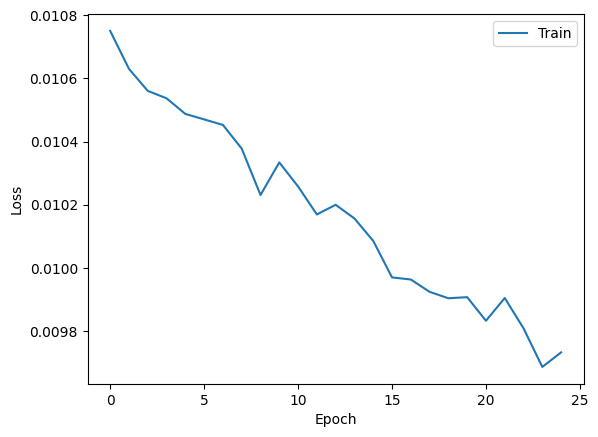

In [98]:

optimizer = torch.optim.Adam(cl.parameters(), lr=0.0005)
all_loss, all_val_loss = train_cl(cl, train_dataloader, val_dataloader, 25)
fig, ax  = plt.subplots()
ax.plot(all_loss, label='Train')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

In [67]:
cl.eval()
accuracy = 0
epoch = 1
with tqdm(train_dataloader, unit="batch") as tepoch:
        for data in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            inputs, labels = data
            inputs = inputs.detach().to('cuda')
            labels = labels.unsqueeze(1).float().detach().to('cuda')
            outputs = cl(inputs)
            #print(labels)
            #print(outputs)
            accuracy += (get_accuracy(labels, outputs))
print(accuracy/len(train_dataloader.dataset))

Epoch 1: 100%|███████████████████████████████████████████████████████| 834/834 [00:43<00:00, 19.10batch/s]

0.8484859841103283


In [99]:
cl.eval()
accuracy = 0
epoch = 1
with tqdm(train_dataloader, unit="batch") as tepoch:
        for data in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            inputs, labels = data
            inputs = inputs.detach().to('cuda')
            labels = labels.unsqueeze(1).float().detach().to('cuda')
            outputs = cl(inputs)
            #print(labels)
            #print(outputs)
            accuracy += (get_accuracy(labels, outputs))
print(accuracy/len(train_dataloader.dataset))

Epoch 1: 100%|███████████████████████████████████████████████████████| 834/834 [00:45<00:00, 18.48batch/s]

0.8450382251536501


In [112]:
torch.save(cl.state_dict(), 'cl.pt')

Epoch 1: 100%|███████████████████████████████████████████████████████| 834/834 [03:48<00:00,  3.66batch/s]


Epoch: 1, loss: 0.009709358223429275


Epoch 2: 100%|███████████████████████████████████████████████████████| 834/834 [01:37<00:00,  8.52batch/s]


Epoch: 2, loss: 0.009692378908400235


Epoch 3: 100%|███████████████████████████████████████████████████████| 834/834 [01:37<00:00,  8.59batch/s]


Epoch: 3, loss: 0.009592866795055156


Epoch 4: 100%|███████████████████████████████████████████████████████| 834/834 [01:38<00:00,  8.49batch/s]


Epoch: 4, loss: 0.009599627510356486


Epoch 5: 100%|███████████████████████████████████████████████████████| 834/834 [01:37<00:00,  8.52batch/s]


Epoch: 5, loss: 0.009475008522991994


Epoch 6: 100%|███████████████████████████████████████████████████████| 834/834 [01:37<00:00,  8.56batch/s]


Epoch: 6, loss: 0.009531154148610095


Epoch 7: 100%|███████████████████████████████████████████████████████| 834/834 [01:37<00:00,  8.53batch/s]


Epoch: 7, loss: 0.009475771080869513


Epoch 8: 100%|███████████████████████████████████████████████████████| 834/834 [01:37<00:00,  8.53batch/s]


Epoch: 8, loss: 0.009426062531839637


Epoch 9: 100%|███████████████████████████████████████████████████████| 834/834 [01:37<00:00,  8.51batch/s]


Epoch: 9, loss: 0.009349455502430926


Epoch 10: 100%|██████████████████████████████████████████████████████| 834/834 [01:37<00:00,  8.52batch/s]


Epoch: 10, loss: 0.009336904988246797


Epoch 11: 100%|██████████████████████████████████████████████████████| 834/834 [01:37<00:00,  8.51batch/s]


Epoch: 11, loss: 0.009341253420044021


Epoch 12: 100%|██████████████████████████████████████████████████████| 834/834 [01:38<00:00,  8.49batch/s]


Epoch: 12, loss: 0.009342836345927216


Epoch 13: 100%|██████████████████████████████████████████████████████| 834/834 [01:38<00:00,  8.47batch/s]


Epoch: 13, loss: 0.00928997720927201


Epoch 14: 100%|██████████████████████████████████████████████████████| 834/834 [01:38<00:00,  8.50batch/s]


Epoch: 14, loss: 0.009146853123798915


Epoch 15: 100%|██████████████████████████████████████████████████████| 834/834 [01:37<00:00,  8.58batch/s]


Epoch: 15, loss: 0.009100341196199162


Epoch 16: 100%|██████████████████████████████████████████████████████| 834/834 [01:37<00:00,  8.59batch/s]


Epoch: 16, loss: 0.009214947256465541


Epoch 17: 100%|██████████████████████████████████████████████████████| 834/834 [01:39<00:00,  8.42batch/s]


Epoch: 17, loss: 0.00906242502387264


Epoch 18: 100%|██████████████████████████████████████████████████████| 834/834 [01:44<00:00,  7.94batch/s]


Epoch: 18, loss: 0.00908433064330314


Epoch 19: 100%|██████████████████████████████████████████████████████| 834/834 [01:42<00:00,  8.14batch/s]


Epoch: 19, loss: 0.009049489601928333


Epoch 20: 100%|██████████████████████████████████████████████████████| 834/834 [01:38<00:00,  8.44batch/s]


Epoch: 20, loss: 0.009015146654371182


Epoch 21: 100%|██████████████████████████████████████████████████████| 834/834 [01:39<00:00,  8.41batch/s]


Epoch: 21, loss: 0.008895021815675521


Epoch 22: 100%|██████████████████████████████████████████████████████| 834/834 [01:42<00:00,  8.15batch/s]


Epoch: 22, loss: 0.008909542537949787


Epoch 23: 100%|██████████████████████████████████████████████████████| 834/834 [01:44<00:00,  7.97batch/s]


Epoch: 23, loss: 0.008770899450664147


Epoch 24: 100%|██████████████████████████████████████████████████████| 834/834 [01:40<00:00,  8.32batch/s]


Epoch: 24, loss: 0.008842528466955598


Epoch 25: 100%|██████████████████████████████████████████████████████| 834/834 [01:41<00:00,  8.20batch/s]


Epoch: 25, loss: 0.0088246260812804


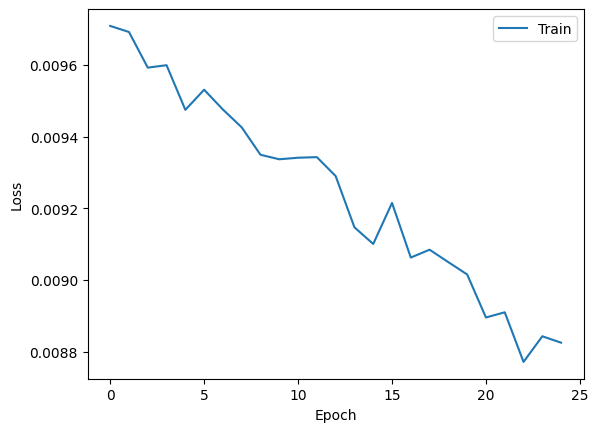

In [166]:

optimizer = torch.optim.Adam(cl.parameters(), lr=0.0005)
all_loss, all_val_loss = train_cl(cl, train_dataloader, val_dataloader, 10)
fig, ax  = plt.subplots()
ax.plot(all_loss, label='Train')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
torch.save(cl.state_dict(), 'cl_png.pt')

Epoch 1: 100%|███████████████████████████████████████████████████████| 834/834 [01:57<00:00,  7.08batch/s]


Epoch: 1, loss: 0.011810959390642545


Epoch 2: 100%|███████████████████████████████████████████████████████| 834/834 [02:00<00:00,  6.91batch/s]


Epoch: 2, loss: 0.011729575668477954


Epoch 3: 100%|███████████████████████████████████████████████████████| 834/834 [01:59<00:00,  6.99batch/s]


Epoch: 3, loss: 0.011708322347322874


Epoch 4: 100%|███████████████████████████████████████████████████████| 834/834 [02:04<00:00,  6.71batch/s]


Epoch: 4, loss: 0.01169196517392267


Epoch 5: 100%|███████████████████████████████████████████████████████| 834/834 [02:00<00:00,  6.90batch/s]


Epoch: 5, loss: 0.011729928333015746


Epoch 6: 100%|███████████████████████████████████████████████████████| 834/834 [02:00<00:00,  6.93batch/s]


Epoch: 6, loss: 0.011601612951342374


Epoch 7: 100%|███████████████████████████████████████████████████████| 834/834 [02:05<00:00,  6.66batch/s]


Epoch: 7, loss: 0.0116962398850673


Epoch 8: 100%|███████████████████████████████████████████████████████| 834/834 [01:59<00:00,  6.96batch/s]


Epoch: 8, loss: 0.011632195038807802


Epoch 9: 100%|███████████████████████████████████████████████████████| 834/834 [01:58<00:00,  7.04batch/s]


Epoch: 9, loss: 0.011655137048965272


Epoch 10: 100%|██████████████████████████████████████████████████████| 834/834 [01:59<00:00,  6.96batch/s]


Epoch: 10, loss: 0.011591488069665788


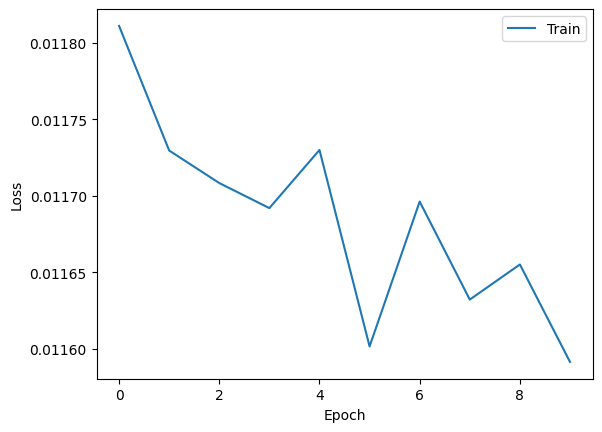

In [211]:

optimizer = torch.optim.Adam(cl.parameters(), lr=0.0003)
all_loss, all_val_loss = train_cl(cl, train_dataloader, val_dataloader, 10)
fig, ax  = plt.subplots()
ax.plot(all_loss, label='Train')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
torch.save(cl.state_dict(), 'cl_png_4.pt')

In [212]:

torch.save(cl.state_dict(), 'cl_png_4.pt')

In [ ]:

optimizer = torch.optim.Adam(cl.parameters(), lr=0.0005)
all_loss, all_val_loss = train_cl(cl, train_dataloader, val_dataloader, 10)
fig, ax  = plt.subplots()
ax.plot(all_loss, label='Train')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
torch.save(cl.state_dict(), 'cl_png.pt')

In [50]:

from torchsummary import summary

In [378]:

summary(cl, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]         147,584
         MaxPool2d-8          [-1, 128, 14, 14]               0
            Linear-9                  [-1, 128]       3,211,392
Total params: 3,451,648
Trainable params: 3,451,648
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 27.75
Params size (MB): 13.17
Estimated Total Size (MB): 41.11
------------------------------------

In [51]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

In [52]:
import torchvision

In [68]:

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
def FRCNN():
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn()
    model.roi_heads.box_predictor = FastRCNNPredictor(model.roi_heads.box_predictor.cls_score.in_features, 2)
    return model

In [77]:
frcnn = FRCNN().cuda()
optimizer = torch.optim.Adam(frcnn.parameters(), lr=1e-4, weight_decay=0.0005)


In [78]:
def train_frcnn(frcnn, train_dataloader, val_dataloader, e):
    all_loss = []
    all_val_loss = []
    for epoch in range(1, e+1):
        running_loss = 0
        val_running_loss = 0
        torch.cuda.empty_cache()
        with tqdm(train_dataloader, unit="batch") as tepoch:
            frcnn.train()
            for data in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                inputs, targets = data
                inputs = list(input.detach().to('cuda') for input in inputs)
                targets = [{key: value.detach().to('cuda') for key, value in target.items()} for target in targets]
                optimizer.zero_grad()
                losses = frcnn(inputs, targets)
                loss = sum(loss for loss in losses.values())
                loss.backward()
                optimizer.step()
                #accuracy.append(get_accuracy(labels, outputs))
                running_loss += loss.item()
                # tepoch.set_postfix(loss=running_loss)#, accuracy=sum(accuracy)/len(accuracy))
        running_loss = running_loss/len(train_dataloader.dataset)
        print(f'Epoch: {epoch}, loss: {running_loss}')        
        all_loss.append(running_loss)
        """        
        with tqdm(val_dataloader, unit="batch") as tepoch:
            for data in tepoch:
                inputs, targets = data
                inputs = list(input.detach().to('cuda') for input in inputs)
                targets = [{key: value.detach().to('cuda') for key, value in t.items()} for target in targets]
                optimizer.zero_grad()
                with torch.no_grad():
                    losses = frcnn(inputs, targets)
                loss = sum(loss for loss in losses.values())
                #val_accuracy.append(get_accuracy(labels, outputs))
                val_running_loss += loss.item()
                # tepoch.set_postfix(val_loss=val_running_loss)#, val_accuracy=sum(val_accuracy)/len(val_accuracy))
        val_running_loss = val_running_loss/len(val_dataloader.dataset)    
        print(f'Epoch: {epoch}, val loss: {val_running_loss}')
        all_val_loss.append(val_running_loss)
        """
    return all_loss, all_val_loss

In [79]:
train_frcnn(frcnn, train_dataloader_box, val_dataloader_box, 15)

Epoch 1: 100%|███████████████████████████████████████████████████████| 188/188 [01:32<00:00,  2.02batch/s]


Epoch: 1, loss: 0.027536151027251148


Epoch 2: 100%|███████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.05batch/s]


Epoch: 2, loss: 0.026469373467043093


Epoch 3: 100%|███████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.05batch/s]


Epoch: 3, loss: 0.02533608565945984


Epoch 4: 100%|███████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.06batch/s]


Epoch: 4, loss: 0.024461027271971254


Epoch 5: 100%|███████████████████████████████████████████████████████| 188/188 [01:33<00:00,  2.02batch/s]


Epoch: 5, loss: 0.023455292878750554


Epoch 6: 100%|███████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.06batch/s]


Epoch: 6, loss: 0.022500944906921286


Epoch 7: 100%|███████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.06batch/s]


Epoch: 7, loss: 0.02152734774791314


Epoch 8: 100%|███████████████████████████████████████████████████████| 188/188 [01:33<00:00,  2.01batch/s]


Epoch: 8, loss: 0.02106343579546103


Epoch 9: 100%|███████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.06batch/s]


Epoch: 9, loss: 0.019993559249781485


Epoch 10: 100%|██████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.09batch/s]


Epoch: 10, loss: 0.019414187900360157


Epoch 11: 100%|██████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.08batch/s]


Epoch: 11, loss: 0.019145243370525058


Epoch 12: 100%|██████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.05batch/s]


Epoch: 12, loss: 0.01838933983823893


Epoch 13: 100%|██████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.08batch/s]


Epoch: 13, loss: 0.01783063205693931


Epoch 14: 100%|██████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.10batch/s]


Epoch: 14, loss: 0.017392371709911487


Epoch 15: 100%|██████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.08batch/s]

Epoch: 15, loss: 0.017135545209853234


([0.027536151027251148,
  0.026469373467043093,
  0.02533608565945984,
  0.024461027271971254,
  0.023455292878750554,
  0.022500944906921286,
  0.02152734774791314,
  0.02106343579546103,
  0.019993559249781485,
  0.019414187900360157,
  0.019145243370525058,
  0.01838933983823893,
  0.01783063205693931,
  0.017392371709911487,
  0.017135545209853234],
 [])

In [174]:

optimizer = torch.optim.Adam(frcnn.parameters(), lr=0.0002, weight_decay=0.0005)
train_frcnn(frcnn, train_dataloader_box, val_dataloader_box, 15)

Epoch 1: 100%|███████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.09batch/s]


Epoch: 1, loss: 0.023026115523127024


Epoch 2: 100%|███████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.07batch/s]


Epoch: 2, loss: 0.021761349228248544


Epoch 3: 100%|███████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.06batch/s]


Epoch: 3, loss: 0.020920408412526625


Epoch 4: 100%|███████████████████████████████████████████████████████| 188/188 [01:32<00:00,  2.04batch/s]


Epoch: 4, loss: 0.020593547005099768


Epoch 5: 100%|███████████████████████████████████████████████████████| 188/188 [01:32<00:00,  2.04batch/s]


Epoch: 5, loss: 0.01999496354294553


Epoch 6: 100%|███████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.09batch/s]


Epoch: 6, loss: 0.019003213968819488


Epoch 7: 100%|███████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.08batch/s]


Epoch: 7, loss: 0.019511977573751373


Epoch 8: 100%|███████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.09batch/s]


Epoch: 8, loss: 0.01911035812127138


Epoch 9: 100%|███████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.06batch/s]


Epoch: 9, loss: 0.018691831333432607


Epoch 10: 100%|██████████████████████████████████████████████████████| 188/188 [01:33<00:00,  2.00batch/s]


Epoch: 10, loss: 0.018271273694788703


Epoch 11: 100%|██████████████████████████████████████████████████████| 188/188 [01:32<00:00,  2.04batch/s]


Epoch: 11, loss: 0.018170061166177014


Epoch 12: 100%|██████████████████████████████████████████████████████| 188/188 [01:37<00:00,  1.92batch/s]


Epoch: 12, loss: 0.017838435620565217


Epoch 13: 100%|██████████████████████████████████████████████████████| 188/188 [01:37<00:00,  1.94batch/s]


Epoch: 13, loss: 0.017421805592909387


Epoch 14: 100%|██████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.05batch/s]


Epoch: 14, loss: 0.017635435178251325


Epoch 15: 100%|██████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.08batch/s]

Epoch: 15, loss: 0.017363751610754652


([0.023026115523127024,
  0.021761349228248544,
  0.020920408412526625,
  0.020593547005099768,
  0.01999496354294553,
  0.019003213968819488,
  0.019511977573751373,
  0.01911035812127138,
  0.018691831333432607,
  0.018271273694788703,
  0.018170061166177014,
  0.017838435620565217,
  0.017421805592909387,
  0.017635435178251325,
  0.017363751610754652],
 [])

In [177]:
train_frcnn(frcnn, train_dataloader_box, val_dataloader_box, 12)

Epoch 1: 100%|███████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.09batch/s]


Epoch: 1, loss: 0.016840188089245093


Epoch 2: 100%|███████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.10batch/s]


Epoch: 2, loss: 0.01682715038121421


Epoch 3: 100%|███████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.10batch/s]


Epoch: 3, loss: 0.016854831870801435


Epoch 4: 100%|███████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.10batch/s]


Epoch: 4, loss: 0.01675615715468953


Epoch 5: 100%|███████████████████████████████████████████████████████| 188/188 [01:26<00:00,  2.17batch/s]


Epoch: 5, loss: 0.016941081407818886


Epoch 6: 100%|███████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.08batch/s]


Epoch: 6, loss: 0.01633108854392966


Epoch 7: 100%|███████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.08batch/s]


Epoch: 7, loss: 0.016160874131196986


Epoch 8: 100%|███████████████████████████████████████████████████████| 188/188 [01:33<00:00,  2.02batch/s]


Epoch: 8, loss: 0.015602004583565617


Epoch 9: 100%|███████████████████████████████████████████████████████| 188/188 [01:32<00:00,  2.04batch/s]


Epoch: 9, loss: 0.015819662365212254


Epoch 10: 100%|██████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.10batch/s]


Epoch: 10, loss: 0.016194806281162436


Epoch 11: 100%|██████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.07batch/s]


Epoch: 11, loss: 0.016285610849351307


Epoch 12: 100%|██████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.10batch/s]

Epoch: 12, loss: 0.015229844543351701


([0.016840188089245093,
  0.01682715038121421,
  0.016854831870801435,
  0.01675615715468953,
  0.016941081407818886,
  0.01633108854392966,
  0.016160874131196986,
  0.015602004583565617,
  0.015819662365212254,
  0.016194806281162436,
  0.016285610849351307,
  0.015229844543351701],
 [])

In [215]:
torch.save(frcnn.state_dict(), 'mobile_png_1.pth')

In [111]:
torch.save(frcnn.state_dict(), 'mobile_attempt_1.pth')

In [74]:
def load_model(path_model, model_type, lr, wd=0):
    """
    Loads in model
    path_model - path to model
    model_type - builder function
    """
    model = model_type()
    model.load_state_dict(torch.load(path_model))
    return model

In [75]:
def load_models(path_cl, path_det):
    """
    Loads in both models
    path_cl - path to classification model
    path_det - path to detection model
    """
    cl = load_model(path_cl, Classifier, 0.001)
    cl = cl.cuda()
    frcnn = load_model(path_det, FRCNN, 0.0001, wd = 0.0005)
    frcnn = frcnn.cuda()
    return cl, frcnn

    


In [76]:
cl, frcnn = load_models("cl.pt", "mobile_attempt_1.pth")

In [81]:
resize = transforms.Resize(size=224)
test_transforms = transforms.Compose([resize,
        transforms.ToTensor()])

In [82]:
import json
from PIL import Image
class TestDataset(Dataset):
    """
    Class that creates dataset for training task
    Arguments:
    img_df - dataframe with cleaned dataset
    img_dir - path to directory with training images
    transform - transforms for input
    """
    def __init__(self, img_dir, img_df, transform):
        self.transform = transform
        self.img_labels = img_df
        self.img_dir = img_dir
        self.mult = INPUT_HEIGHT/1024

    def __len__(self):
        return self.img_labels.shape[0]

    def __getitem__(self, idx):
        patient_id = self.img_labels["patientId"][idx]
        img_path = self.img_dir + f'/{self.img_labels["patientId"][idx]}.dcm'
        ds = dicom.dcmread(img_path)
        image = Image.fromarray(ds.pixel_array)
        # image.show()
        if self.transform:
            image = self.transform(image)
        #print(image)
        #print(patient_id)
        return image, patient_id


In [ ]:
def create_test_df(test_dir):
    test = [f[:-4] for f in os.listdir(test_dir)]
    test = pd.DataFrame({'patientId':test})
    return test

In [90]:
def create_test_df(test_dir):
    test = pd.read_csv('kaggle_set/stage_2_sample_submission.csv')
    #test = test['patientId']
    return test

In [91]:
test_df = create_test_df('kaggle_set/stage_2_test_images')

In [92]:
test_df.head()

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


In [93]:
test_dataset = TestDataset('kaggle_set/stage_2_test_images', img_df = test_df, transform=test_transforms)#, classification=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)#, collate_fn=collate_fn)

In [202]:
from torchvision.ops.boxes import nms

In [213]:
def print_results(model_cl, model_frcnn, generator, iou_threshold=0.15, threshold=0.8):
    cl, frcnn = model_cl, model_frcnn
    test_dataloader = generator
    with open('submission.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        field = ["patientId", "PredictionString"]
        writer.writerow(field)
        cl.eval()
        frcnn.eval()
        with tqdm(test_dataloader, unit="batch") as tepoch:
            for data in tepoch:
                tepoch.set_description(f"Testing")
                inputs, labels = data
                inputs = inputs.detach().to('cuda')
                outputs = cl(inputs)
                res = outputs.cpu().detach().numpy()
                mask = [np.round(i) for i in res]
                for i, m in enumerate(mask):
                    if m == 0:
                        writer.writerow([(labels[i]), ""])
                    else:
                        out_box = frcnn([inputs[i]])
                        for o in out_box:
                            scores = np.array(o['scores'].cpu().detach())
                            if len(scores) < 1:
                                writer.writerow([(labels[i]), ""])
                                continue

                            box_list = []
                            boxes = np.array(o['boxes'].cpu().detach())
                            box_i = np.array(o['scores'].cpu().detach()).argmax()
                            ind = nms(o['boxes'], o['scores'], iou_threshold).detach().cpu().numpy()
                            for j, bbox in enumerate(o['boxes'][ind]):
                                if o['scores'][j] > threshold:
                                    box_list += [scores[j], int(boxes[j][0] / test_dataset.mult),
                                                 int(boxes[j][1] / test_dataset.mult),
                                                 int((boxes[j][2] - boxes[j][0]) / test_dataset.mult),
                                                 int((boxes[j][3] - boxes[j][1]) / test_dataset.mult)]
                            if len(box_list) < 1:
                                box_list = [scores[box_i], int(boxes[box_i][0] / test_dataset.mult),
                                            int(boxes[box_i][1] / test_dataset.mult),
                                            int((boxes[box_i][2] - boxes[box_i][0]) / test_dataset.mult),
                                            int((boxes[box_i][3] - boxes[box_i][1]) / test_dataset.mult)]

                            box_list = " ".join(str(element) for element in box_list)
                            writer.writerow([(labels[i]), box_list])
            


In [217]:
print_results(cl, frcnn, test_dataloader, 0.1, 0.5)

Testing: 100%|█████████████████████████████████████████████████████████| 94/94 [00:52<00:00,  1.78batch/s]


In [95]:
import csv